# Recovering eccentric 'signal' with eccentric waveform template - likelihood distribution over 1D parameter space of eccentricity

Simona Miller, LIGO SURF 2018 (Last edited: August 7, 2018)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pycbc import psd as pypsd
from pycbc.waveform.generator import FDomainDetFrameGenerator, FDomainCBCGenerator
from pycbc import inference
from pycbc.rate import confidence_interval_min_width as CI

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18)

## Global Variables, Waveform Generator, & PSD 

In [3]:
# Global variables
seglen = 10
sample_rate = 2048
N = seglen*sample_rate/2+1
fmin = 20.

tsig, ra, dec, pol = 3.1, 1.37, -1.26, 2.76

mass_range = [5,20,60]
snr_range = [5,10,20,50,100]
true_ecc = [0.001, 0.01, 0.1]

de = 0.0005
ecc_range = np.arange(0.0, 0.2, de)


# Waveform generator
generator = FDomainDetFrameGenerator(FDomainCBCGenerator, 
                                     0., 
                                     variable_args=['eccentricity', 'mass1', 'mass2', 'distance'], 
                                     detectors=['H1', 'L1'], 
                                     delta_f=1./seglen, 
                                     f_lower=fmin, 
                                     approximant='EccentricFD',  
                                     tc=tsig, 
                                     ra=ra, 
                                     dec=dec, 
                                     polarization=pol)

# PSD
psd = pypsd.analytical.aLIGODesignSensitivityP1200087(N, 1./seglen, 20.)
psds = {'H1': psd, 'L1': psd}

## Necessary Helper Functions

In [4]:
def SNRtoDistance(SNR, ecc, mass, psd=psd, f_lower=fmin):

    data0 = generator.generate(eccentricity=ecc, mass1=mass, mass2=mass, distance=1)
    
    likelihood_eval = inference.GaussianLikelihood(['eccentricity'],
                                                       generator, data0, fmin, psds=psds, return_meta=False)
    SNR0 = likelihood_eval.snr()
        
    distance = int(float(SNR0)/SNR)
    
    return distance

In [5]:
def Normalize(lnlikelihood_dist, de): 
    
    lnlik = [x-max(lnlikelihood_dist)+20 for x in lnlikelihood_dist]
    
    norm_const = 1.0/(np.sum(np.exp(lnlik[:]))*de)
    
    norm = [norm_const*np.exp(x) for x in lnlik]
 
    return norm 

## Generate Likelihood Distributions

In [6]:
loglikelihood = {}

for mass in mass_range: 
    for SNR in snr_range:
        for e0 in true_ecc:
        
            dist = SNRtoDistance(SNR, e0, mass)

            signal = generator.generate(eccentricity=e0, mass1=mass, mass2=mass, distance=dist)
        
            likelihood_eval = inference.GaussianLikelihood(['eccentricity'],
                                                       generator, signal, fmin, psds=psds, return_meta=False)
        
            lnlik = []
            for e in ecc_range:    
                lnlik.append(likelihood_eval.loglr(eccentricity=e))
        
            norm = Normalize(lnlik,de)
            
            loglikelihood[(mass, SNR, e0)] = norm
        
            print 'Generated distribution for m={}, SNR={}, e0={}'.format(mass,SNR,e0)

Generated distribution for m=5, SNR=5, e0=0.001
Generated distribution for m=5, SNR=5, e0=0.01
Generated distribution for m=5, SNR=5, e0=0.1
Generated distribution for m=5, SNR=10, e0=0.001
Generated distribution for m=5, SNR=10, e0=0.01
Generated distribution for m=5, SNR=10, e0=0.1
Generated distribution for m=5, SNR=20, e0=0.001
Generated distribution for m=5, SNR=20, e0=0.01
Generated distribution for m=5, SNR=20, e0=0.1
Generated distribution for m=5, SNR=50, e0=0.001
Generated distribution for m=5, SNR=50, e0=0.01
Generated distribution for m=5, SNR=50, e0=0.1
Generated distribution for m=5, SNR=100, e0=0.001
Generated distribution for m=5, SNR=100, e0=0.01
Generated distribution for m=5, SNR=100, e0=0.1
Generated distribution for m=20, SNR=5, e0=0.001
Generated distribution for m=20, SNR=5, e0=0.01
Generated distribution for m=20, SNR=5, e0=0.1
Generated distribution for m=20, SNR=10, e0=0.001
Generated distribution for m=20, SNR=10, e0=0.01
Generated distribution for m=20, SNR=

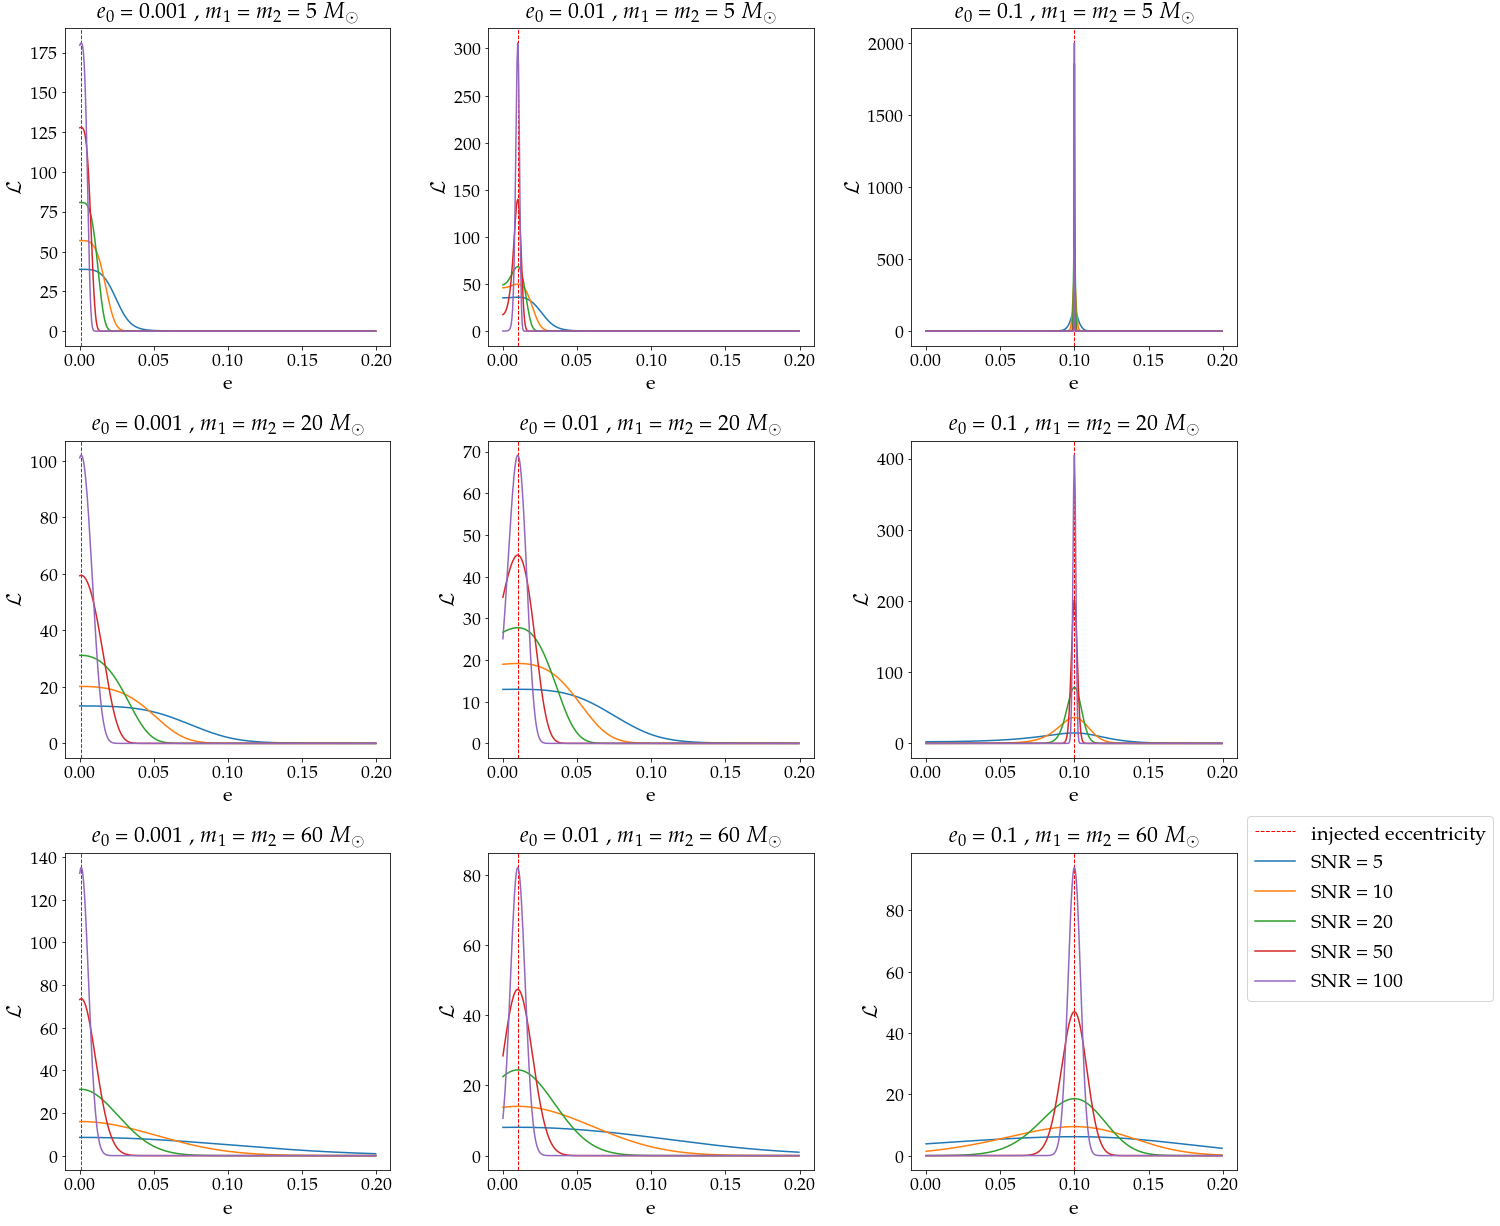

In [7]:
plt.figure(figsize=(7*len(mass_range),7*len(true_ecc)))

i = 1

for m in mass_range:
    for e0 in true_ecc: 
        
        plt.subplot(len(true_ecc),len(mass_range),i)
        plt.title(r'$e_0$ = {} , $m_1$ = $m_2$ = {} $M_\odot$'.format(e0, m), fontsize=22)
        plt.xlabel('e', fontsize=20)
        plt.ylabel(r'$\mathcal{L}$', fontsize=20)
        plt.axvline(x=e0, color='r', linestyle='dashed', linewidth=1.0, label='injected eccentricity')
        
        for SNR in snr_range: 
                
            key = (m,SNR,e0)
            lik = loglikelihood[key]
            plt.plot(ecc_range, lik, label="SNR = {}".format(SNR))
        
        i+=1
        
        
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.legend(fontsize=20,loc='lower left', bbox_to_anchor=(1, 0.5))
plt.savefig('likelihood_pycbc.png')
plt.show()

## Confidence Intervals

In [8]:
# Returns indexes for desired confidence interval 
def confidence_interval(data, dx, confidence=0.90):
    data_s = sorted(data, reverse=True)
    
    tot = 0
    for i in range(len(data_s)): 
        tot+=(data_s[i]*dx)
        if tot >= confidence:
            d1 = data_s[i] 
            d2 = data_s[i-1]
            break 
            
    idx1 = data.index(d1)
    idx2 = data.index(d2)
            
    if idx1 - idx2 == 1: 
        return 0, idx1
    else: 
        return idx1, idx2

In [9]:
lik = loglikelihood[(20, 20, 0.1)]
idx1, idx2 = confidence_interval(lik,de)
print idx1, idx2

182 216


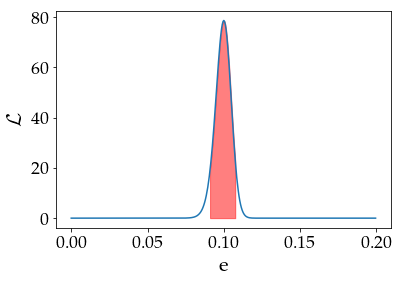

In [10]:
plt.plot(ecc_range, lik)
plt.fill_between(ecc_range[idx1:idx2], lik[idx1:idx2], alpha=0.5, color='r')
plt.xlabel('e', fontsize=20)
plt.ylabel(r'$\mathcal{L}$', fontsize=20)
plt.show()

In [11]:
print np.sum(lik[idx1:idx2])*de

0.897415960094


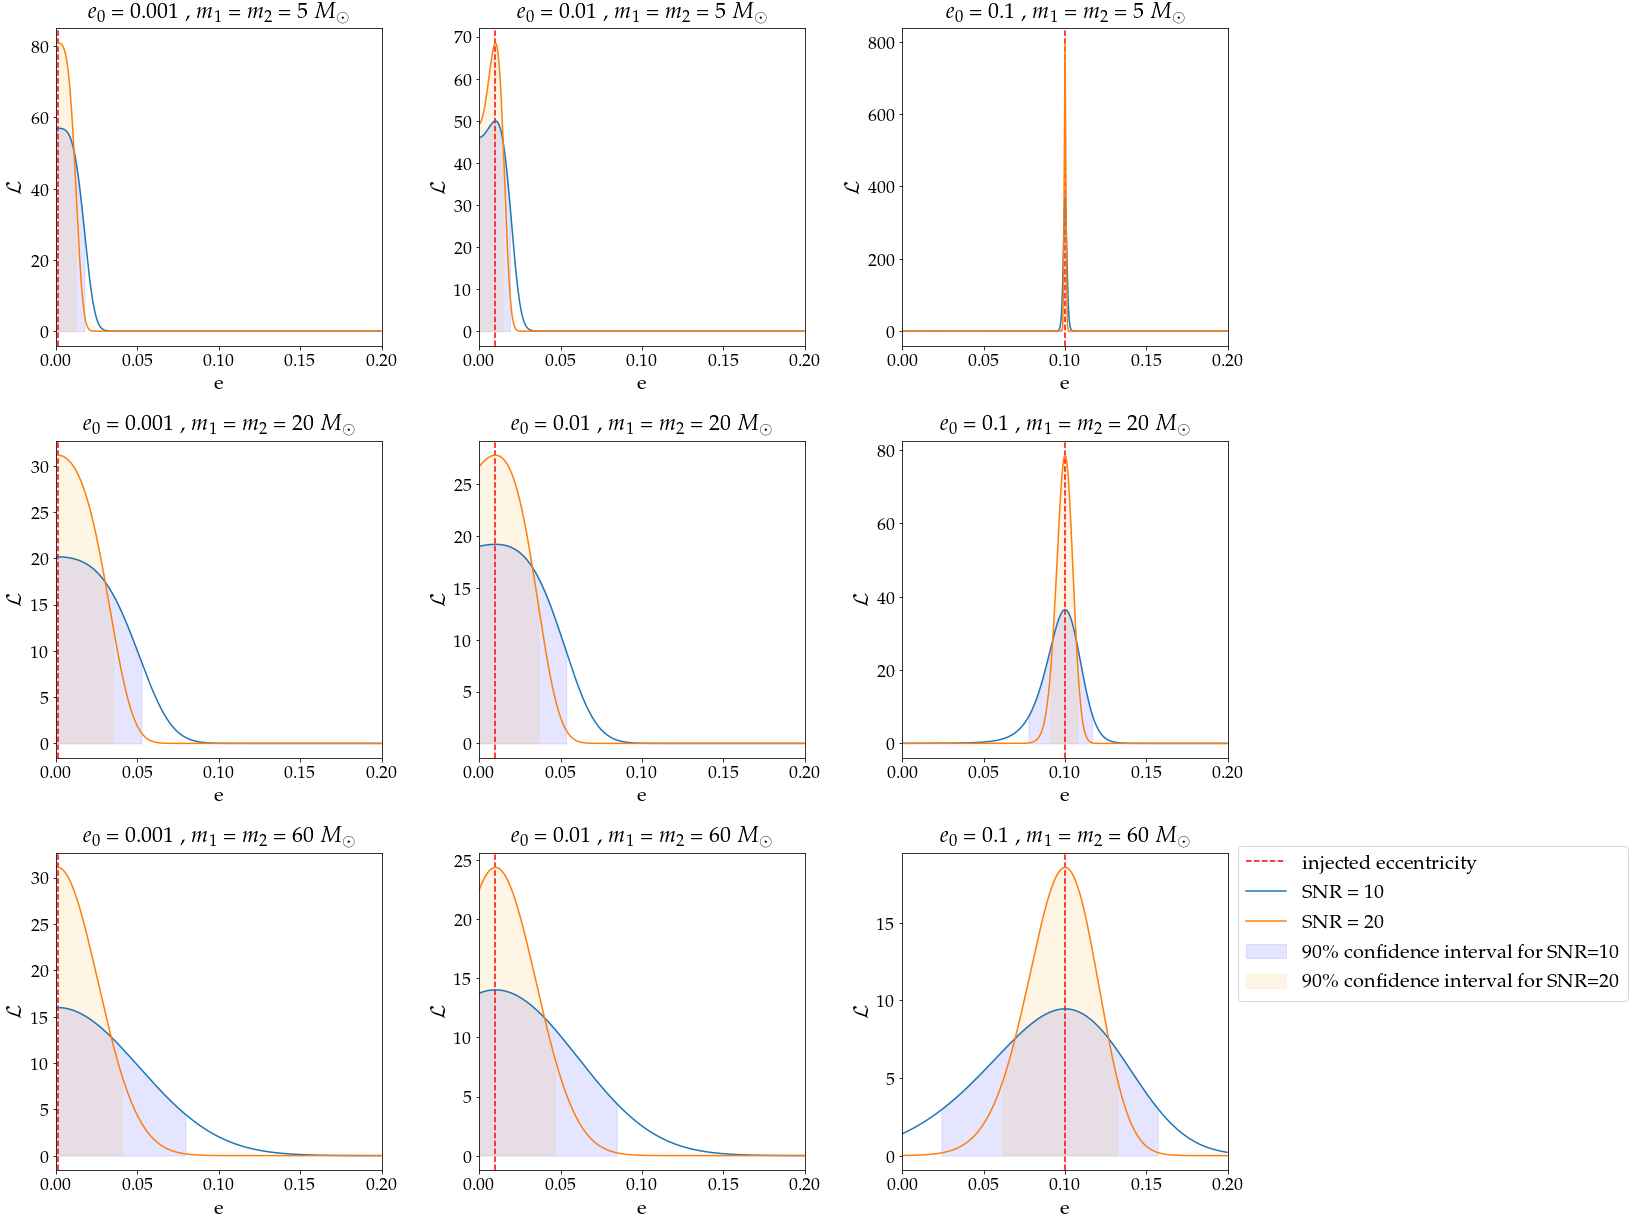

In [12]:
plt.figure(figsize=(7*len(mass_range),7*len(true_ecc)))

i = 1

for m in mass_range:
    for e0 in true_ecc: 
        
        plt.subplot(len(true_ecc),len(mass_range),i)
        plt.title(r'$e_0$ = {} , $m_1$ = $m_2$ = {} $M_\odot$'.format(e0, m), fontsize=22)
        plt.xlabel('e', fontsize=20)
        plt.ylabel(r'$\mathcal{L}$', fontsize=20)
        plt.axvline(x=e0, color='r', linestyle='dashed', label='injected eccentricity')
        
        for SNR in [10,20]:
            key = (m,SNR,e0)
            lik = loglikelihood[key]
            idx1, idx2 = confidence_interval(lik,de)
        
            plt.plot(ecc_range, lik, label="SNR = {}".format(SNR))
            
            if SNR==10:
                plt.fill_between(ecc_range[idx1:idx2], lik[idx1:idx2], alpha=0.1, 
                             color='blue', label="90\% confidence interval for SNR=10")
            if SNR==20:
                plt.fill_between(ecc_range[idx1:idx2], lik[idx1:idx2], alpha=0.1, 
                             color='orange', label="90\% confidence interval for SNR=20")
            plt.xlim(0,0.2)
        
        i+=1
        
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.legend(fontsize=20,loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()